In [89]:
!pip install python-resize-image
!pip install -U scipy==1.2.0
!pip install python-archive

import numpy as np
from numpy.random import *

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from skimage import data, io, transform
import matplotlib.pyplot as plt
from archive import Archive
from archive import extract
from PIL import Image
from resizeimage import resizeimage
from __future__ import print_function

import pandas as pd
import cv2
from scipy.misc import imresize, imrotate, imsave

from os import listdir
from os.path import isfile, join

Requirement already up-to-date: scipy==1.2.0 in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [90]:
!wget https://s3-eu-west-1.amazonaws.com/handwriting-curated-database/curated.tar.gz
extract('curated.tar.gz', 'curated_data')
path = 'curated_data' 

--2020-05-31 16:41:17--  https://s3-eu-west-1.amazonaws.com/handwriting-curated-database/curated.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.110.43
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.110.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30058219 (29M) [application/x-gzip]
Saving to: ‘curated.tar.gz.6’

curated.tar.gz.6    100%[===================>]  28.67M  6.90MB/s    in 4.2s    

2020-05-31 16:41:23 (6.90 MB/s) - ‘curated.tar.gz.6’ saved [30058219/30058219]



In [91]:
#punc = '!\"\'()*+,-./:;<=>?[]^_`{|}~' #remove @=64, $=36, &=38, #=35, %=37
punc = '!,.?'
punc_encoding = {ord(punc[i]): i for i in range(len(punc))}

print(punc_encoding)

{33: 0, 44: 1, 46: 2, 63: 3}


(1207, 28, 28)
(1207,)
0


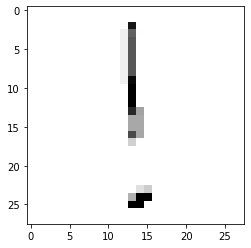

In [92]:
images, labels = [], []

for p in punc_encoding:
  path_img = path + '/curated/' + str(p) + '/'
  for file_name in [f for f in listdir(path_img) if isfile(join(path_img, f))]:
      img = cv2.imread(path_img + file_name, 0)
      img = cv2.resize(img,(28, 28), interpolation = cv2.INTER_CUBIC)
      images += [img]
      labels += [punc_encoding[p]]

images = np.array(images, dtype=np.uint8)
labels = np.array(labels, dtype=np.uint8)

print(images.shape)
print(labels.shape)
plt.imshow(images[0], cmap='gray_r')
print(labels[0])

In [0]:
def define_discriminator(input_shape=(28, 28, 1), n_classes=4):
    # label input and embedding
    label_in = Input(shape=(1, ))
    print(label_in.shape)
    emb = Embedding(n_classes, 50)(label_in)
    print(emb.shape)
    label_h = Dense(input_shape[0] * input_shape[1])(emb)
    print(label_h.shape)
    re_label_h = Reshape((input_shape[0], input_shape[1], 1))(label_h)
    print(re_label_h.shape)
    # image input
    image_in = Input(shape=input_shape)
    # combine inputs
    merge = Concatenate()([image_in, re_label_h])
    # convnet
    h1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(h1)
    h2 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(h2)
    # fully connected net
    fl = Flatten()(r2) 
    dr = Dropout(0.4)(fl)
    # output
    out = Dense(1, activation='sigmoid')(dr)
    # define and compile model
    model = Model([image_in, label_in], out)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    return model

In [0]:
def define_generator(latent_dim, n_classes=4):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(7*7)(emb)
    re_label_h = Reshape((7, 7, 1))(label_h)
    # noisy image input
    noise_in = Input(shape=(latent_dim,))
    noise_h = Dense(128*7*7)(noise_in)
    noise_r = LeakyReLU(alpha=0.2)(noise_h)
    re_noise_r = Reshape((7, 7, 128))(noise_r)
    # combine inputs
    merge = Concatenate()([re_noise_r, re_label_h])
    # upsampling
    u1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(u1)
    u2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(u2)
    # output
    out = Conv2D(1, (7, 7), activation='tanh', padding='same')(r2)
    # define model
    model = Model([noise_in, label_in], out)
    return model

In [0]:
def define_gan(gen, dis):
    # discriminator shouldn't be trainable
    dis.trainable = False
    # get generator inputs and outputs
    gen_noise, gen_label = gen.input
    gen_output = gen.output
    print
    # feed to discriminator
    gan_output = dis([gen_output, gen_label])
    # define and compile GAN model
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
def prepare_inputs(images, labels):
    if len(images.shape) > 2:
      images = np.squeeze(images)
    X = np.expand_dims(images, axis=-1)
    X = X.astype('float32')
    X = (X-127.5) / 127.5
    return [X, labels]
    
def generate_real_samples(images, labels, n_samples):
    rand_index = randint(0, images.shape[0], n_samples)
    X, labels = images[rand_index], labels[rand_index]
    y = np.ones((n_samples, 1)) * 0.9 # discriminator target label
    return [X, labels], y

def generate_latent_noise(latent_dim, n_samples, n_classes=4):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

def generate_fake_samples(gen, latent_dim, n_samples):
    zin, lin = generate_latent_noise(latent_dim, n_samples)
    images = gen.predict([zin, lin])
    y = np.zeros((n_samples, 1))  # discriminator target label
    return [images, lin], y

In [0]:
def train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=100, batch_size=128):
    batch_per_epoch = int(images.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # enumerate epochs
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # train discriminator on real images
            [X_real, labels_real], y_real = generate_real_samples(images, labels, half_batch)
            d_loss1, _ = dis.train_on_batch([X_real, labels_real], y_real)
            # train discriminator on generated images
            [X_fake, labels_fake], y_fake = generate_fake_samples(gen, latent_dim, half_batch)
            #d_loss2 = dis.evaluate([X_fake, labels_fake], y_fake)[0]
            #if d_loss2 > 0.5:
            d_loss2, _ = dis.train_on_batch([X_fake, labels_fake], y_fake)
            # prepare generator input
            [zin, label_in] = generate_latent_noise(latent_dim, batch_size)
            # invert labels for fake samples (prevent vanishing gradients)
            y_gan = np.ones((batch_size, 1))
            # update generator loss
            g_loss = gan_model.train_on_batch([zin, label_in], y_gan)
            # output losses
            if j % 50 == 0:
              print('Epoch {}, batch {}/{}:\tDiscriminator: real loss {}, fake loss {}\tGenerator: loss {}'
                  .format(i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    # save the models
    gen.save('generator_punc.h5')
    dis.save('discriminator_punc.h5')
    gan_model.save('gan_punc.h5')    

In [98]:
latent_dim = 100
images, labels = prepare_inputs(images, labels)
print(images.shape, labels.shape)
dis = define_discriminator()
gen = define_generator(latent_dim)
gan_model = define_gan(gen, dis)
print("\nDiscriminator\n")
dis.summary()
print("\nGenerator\n")
gen.summary()
print("\nGAN\n")
gan_model.summary()

(1207, 28, 28, 1) (1207,)
(None, 1)
(None, 1, 50)
(None, 1, 784)
(None, 28, 28, 1)

Discriminator

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 50)        200         input_25[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 1, 784)       39984       embedding_12[0][0]               
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 28, 28, 1)]  0                                     

In [121]:
train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=200, batch_size=128)

Epoch 1, batch 1/9:	Discriminator: real loss 0.17681917548179626, fake loss 0.18403680622577667	Generator: loss 0.8859668970108032
Epoch 2, batch 1/9:	Discriminator: real loss 0.18273191154003143, fake loss 0.20321868360042572	Generator: loss 0.8714427351951599
Epoch 3, batch 1/9:	Discriminator: real loss 0.1765570342540741, fake loss 0.18444958329200745	Generator: loss 0.8832634687423706
Epoch 4, batch 1/9:	Discriminator: real loss 0.20888148248195648, fake loss 0.2167460173368454	Generator: loss 0.8879619240760803
Epoch 5, batch 1/9:	Discriminator: real loss 0.1824904978275299, fake loss 0.20560166239738464	Generator: loss 0.8561676740646362
Epoch 6, batch 1/9:	Discriminator: real loss 0.19257566332817078, fake loss 0.19388973712921143	Generator: loss 0.8708281517028809
Epoch 7, batch 1/9:	Discriminator: real loss 0.19502341747283936, fake loss 0.21551650762557983	Generator: loss 0.8777390718460083
Epoch 8, batch 1/9:	Discriminator: real loss 0.18553996086120605, fake loss 0.20040571

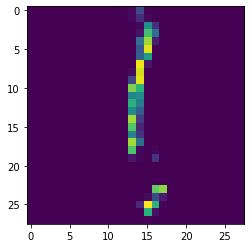

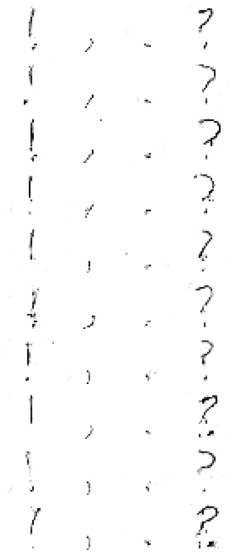

In [124]:
def show_generated(examples, n, c):
  fig = plt.figure(figsize=(c, n))
  for i in range(n*c):
    img = fig.add_subplot(n, c, i+1)
    plt.axis('off')
    plt.imshow(examples[i,:,:,0], cmap='gray_r')
  plt.show()

n = 10
c = 4

model = load_model('generator.h5')
noise, _ = generate_latent_noise(latent_dim, n*c)
labs = np.asarray([x for _ in range(n) for x in range(c)])

X = model.predict([noise, labs])
# scale from [-1, 1] to [0, 1]
X = (X + 1) / 2.0
x = np.squeeze(X[0])
plt.imshow(x)

show_generated(X, n, c)

In [0]:
from google.colab import files

dflag = True
if dflag:
  files.download('generator_punc.h5')
  #files.download('discriminator_punc.h5')
  #files.download('gan_punc.h5')